In [17]:
from qiskit import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
from scipy.linalg import expm, eigvals
pi = np.pi
import pyscf
from qiskit_nature.second_q.drivers import PySCFDriver
import qiskit_nature.units as units
import qiskit_nature.second_q as sq
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, NumPyMinimumEigensolverFactory

In [33]:
# Initialize arrays, that store the result of the calculations later on, as well as the distance, at which the ground state energy is evaluated
distance = np.arange(0.5, 4.1, 0.1)
energy_JW_log = np.zeros(len(distance))
energy_BK_log = np.zeros(len(distance))

# Data from past calculations, that are used to compare the results
energy_BK = np.array([-0.4257    , -0.66983333, -0.83592857, -0.9683    , -1.06588889,
       -1.1382    , -1.17540909, -1.18236667, -1.16286923, -1.13821429,
       -1.12313333, -1.1281    , -1.13336471, -1.14644444, -1.15778421,
       -1.1634    , -1.16660952, -1.16595455, -1.16101739, -1.15163333,
       -1.1303    , -1.10778462, -1.07842963, -1.05245714, -1.02967241,
       -1.00846667, -0.99851935, -0.9886    , -0.9780697 , -0.97278235,
       -0.96968571, -0.96302222, -0.96172973, -0.95934211, -0.95098974,
       -0.9497    ])

energy_JW = np.array([-0.4233    , -0.66733333, -0.83872857, -0.9666    , -1.06668889,
       -1.1365    , -1.17430909, -1.18236667, -1.16516923, -1.13721429,
       -1.12773333, -1.125     , -1.13296471, -1.14484444, -1.15718421,
       -1.1632    , -1.16830952, -1.16815455, -1.16131739, -1.15153333,
       -1.1303    , -1.10588462, -1.08302963, -1.05315714, -1.03477241,
       -1.01296667, -0.99611935, -0.988     , -0.9844697 , -0.97388235,
       -0.96948571, -0.96302222, -0.96262973, -0.95754211, -0.95128974,
       -0.9483    ])

energy_classical = np.array([-0.41078847, -0.67651081, -0.84632598, -0.95759853, -1.03104303,
       -1.07896977, -1.10913729, -1.12669882, -1.13522793, -1.13727594,
       -1.13469066, -1.12881564, -1.12062879, -1.11084598, -1.09999962,
       -1.08849631, -1.07665641, -1.06473935, -1.05295849, -1.04148934,
       -1.030474  , -1.02002392, -1.01022207, -1.00112516, -0.99276613,
       -0.98515682, -0.97829101, -0.97214737, -0.96669267, -0.96188471,
       -0.95767517, -0.95401222, -0.95084267, -0.94811386, -0.94577506,
       -0.94377847])
# Mappers, to map SQ Hamiltonian onto Pauli matrices
BKconverter = sq.mappers.QubitConverter(sq.mappers.BravyiKitaevMapper())
JWconverter = sq.mappers.QubitConverter(sq.mappers.JordanWignerMapper())

# Define Pauli matrices
x = np.array([[0, 1], [1, 0]])
y = np.array([[0, -1j], [1j, 0]])
z = np.array([[1, 0], [0, -1]])
i = np.array([[1, 0], [0, 1]])

for k in range(len(distance)):
    # Initialize Molecule
    driver = PySCFDriver(
        atom ='H 0 0 0; H 0 0 {}'.format(distance[k]),
        unit = units.DistanceUnit.BOHR,
        charge = 0,
        spin = 0,
        basis="sto3g"
    )
    hydrogen = driver.run()

    # Get Hamiltonian and convert it to second quantized form
    hamiltonian = hydrogen.hamiltonian
    sq_form = hamiltonian.second_q_op()
    repulsion = hamiltonian.nuclear_repulsion_energy

    # Map SQ Hamiltonian onto Pauli matrices and store the necessary prefactors in a dictionary
    BKHam = BKconverter.convert(sq_form)
    JWHam = JWconverter.convert(sq_form)
    coeffsBK = dict((x, np.real(y)) for x, y in BKHam.primitive.to_list())
    coeffsJW = dict((x, np.real(y)) for x, y in JWHam.primitive.to_list())
    
    # Build trotterized time evolution operator from both Hamiltonians
    UBK1 = coeffsBK['IIII'] * np.kron(i, np.kron(i, np.kron(i, i))) + coeffsBK['IIIZ'] * np.kron(i, np.kron(i, np.kron(i, z))) + coeffsBK['IIZZ'] * np.kron(i, np.kron(i, np.kron(z, z))) + coeffsBK['IZII'] * np.kron(i, np.kron(z, np.kron(i, i))) + coeffsBK['ZZZI'] * np.kron(z, np.kron(z, np.kron(z, i))) + coeffsBK['IIZI'] * np.kron(i, np.kron(i, np.kron(z, i))) + coeffsBK['IZIZ'] * np.kron(i, np.kron(z, np.kron(i, z))) + coeffsBK['ZZZZ'] * np.kron(z, np.kron(z, np.kron(z, z))) + coeffsBK['IZZZ'] * np.kron(i, np.kron(z, np.kron(z, z))) + coeffsBK['ZZIZ'] * np.kron(z, np.kron(z, np.kron(i, z))) + coeffsBK['ZIZI'] * np.kron(z, np.kron(i, np.kron(z, i)))
    UBK2 = coeffsBK['ZXIX'] * np.kron(z, np.kron(x, np.kron(i, x))) + coeffsBK['IXZX'] * np.kron(i, np.kron(x, np.kron(z, x))) + coeffsBK['ZXZX'] * np.kron(z, np.kron(x, np.kron(z, x))) + coeffsBK['IXIX'] * np.kron(i, np.kron(x, np.kron(i, x)))
    UJW1 = coeffsJW['IIII'] * np.kron(i, np.kron(i, np.kron(i, i))) + coeffsJW['IIIZ'] * np.kron(i, np.kron(i, np.kron(i, z))) + coeffsJW['IIZI'] * np.kron(i, np.kron(i, np.kron(z, i))) + coeffsJW['IZII'] * np.kron(i, np.kron(z, np.kron(i, i))) + coeffsJW['ZIII'] * np.kron(z, np.kron(i, np.kron(i, i))) + coeffsJW['IIZZ'] * np.kron(i, np.kron(i, np.kron(z, z))) + coeffsJW['IZIZ'] * np.kron(i, np.kron(z, np.kron(i, z))) + coeffsJW['ZIIZ'] * np.kron(z, np.kron(i, np.kron(i, z))) + coeffsJW['IZZI'] * np.kron(i, np.kron(z, np.kron(z, i))) + coeffsJW['ZIZI'] * np.kron(z, np.kron(i, np.kron(z, i))) + coeffsJW['ZZII'] * np.kron(z, np.kron(z, np.kron(i, i)))
    UJW2 = coeffsJW['YYYY'] * np.kron(y, np.kron(y, np.kron(y, y))) + coeffsJW['XXXX'] * np.kron(x, np.kron(x, np.kron(x, x)))
    UJW3 = coeffsJW['YYXX'] * np.kron(y, np.kron(y, np.kron(x, x))) + coeffsJW['XXYY'] * np.kron(x, np.kron(x, np.kron(y, y)))
    UJW = np.matmul(expm(-1j*UJW1), np.matmul(expm(-1j*UJW2), expm(-1j*UJW3)))
    UBK = np.matmul(expm(-1j*UBK1), expm(-1j*UBK2))
    
    # Calculate all eigenvalues of the trotterized time evolution operators, take the logarithm and pick out the minimal eigenvalue
    eigenvalBK = np.sort(eigvals(UBK))
    eigenvalJW = np.sort(eigvals(UJW))
    energy_BK_log[k] = np.real(np.amin(1j*np.log(eigenvalBK)))+ repulsion
    energy_JW_log[k] = np.real(np.amin(1j*np.log(eigenvalJW)))+ repulsion
    

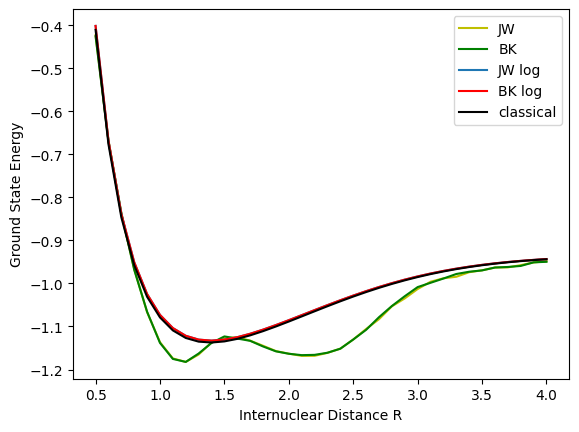

In [34]:
# Plot the data
plt.plot(distance, energy_JW, 'y-', label='JW')
plt.plot(distance, energy_BK, 'g-', label='BK')
plt.plot(distance, energy_JW_log, label='JW log')
plt.plot(distance, energy_BK_log, 'r-', label='BK log')
plt.plot(distance, energy_classical, 'k-', label='classical')
plt.xlabel('Internuclear Distance R')
plt.ylabel('Ground State Energy')
plt.legend()